# Example Scenario

This notebook contains an example setup to run experiments as done in the [paper](https://arxiv.org/abs/2004.07641).

As we are in the process of significantly refactoring the code base and experiments, we did not update the entire experiment notebook done to reproduce the paper experiments, as they are now deprecated.

__If you want to play around and reproduce results currently shown in the arXiv paper, revert to commit__
`28b14a1dca53e12573eabf99317b2c7517c81761`

The notebook is organized as follows:

* In Section 1, we define all the simulation parameters.
* In Section 2, we run all the simulations needed for the experiment.
* In Section 3, we plot the results.

To just regenerate the figures from a summary file containing all the simulation objects of the experiment, you can skip Section 2, and only run the cells in Sections 1 & 3. 

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
%load_ext autoreload
%autoreload 2
from lib.mobilitysim import MobilitySimulator
from lib.data import collect_data_from_df
from lib.calibrationFunctions import gen_initial_seeds, extract_seeds_from_summary, downsample_cases
from lib.plot import Plotter
from lib.measures import *
from lib.experiment import run_experiment, save_summary, load_summary
from lib.calibrationSettings import calibration_lockdown_dates


import matplotlib.pyplot as plt
%matplotlib inline

# converting days to hours
TO_HOURS = 24.0

#### Set the random seed for reproducibility

In [3]:
# Choose random seed
c = 0
np.random.seed(c)

# Define prefix string used to save plots
runstr = f'example_run{c}_'

#### Set the number of roll-outs to simulate

In [4]:
random_repeats = 4 # Set to at least 40 to obtain stable results

#### Define population/mobility parameters

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

Check out `lib/mobility/` and `lib/settings/` for all pre-generated towns in Germany and Switzerland. 

In [5]:
from lib.settings.town_settings_tubingen import *
mob_settings = 'lib/mobility/Tubingen_settings_10.pk'  
country = 'GER'
area = 'TU'
start_date = '2020-03-15'
end_date = '2020-04-15'

seed_summary_path = None # for initial seeding from prior run

#### Set epidemic parameters

Need to be calibrated using Bayesian optimization in order to match real case data, but possible to run experiments without calibrated parameters, as shown here.

In [6]:
beta = 0.50 # this needs to be calibrated

arbitrary_model_params = {
    'betas' : {
        'education': beta,
        'social': beta,
        'bus_stop': beta,
        'office': beta,
        'supermarket': beta}, 
    'beta_household' : beta
}

#### Define Measures to take place during simulation

See `measures.py` for other options.

In [7]:
lockdown_at_day = 14

sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
max_time = TO_HOURS * sim_days # in hours

example_measures = [
    
    # education, social sites, and offices close after 1 week
    BetaMultiplierMeasureByType(
        t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        beta_multiplier={ 
            'education': 0.5, 
            'social': 0.5, 
            'bus_stop': 1.0, 
            'office': 0.5, 
            'supermarket': 1.0
        }),
    
    # less activities of all due to contact constraints after 14 days
    SocialDistancingForAllMeasure(
     t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        p_stay_home=0.5)
]


## 2. Run the simulations

Run the experiment using the parameters defined above and simulate in the future, with additional measures of varying duration.

**WARNING: this cell might take a long time to run depending of the parameters defined above!**

In [8]:
summary_example = run_experiment(
    country=country, 
    area=area, 
    mob_settings=mob_settings,
    start_date=start_date, 
    end_date=end_date, 
    measure_list=example_measures, 
    random_repeats=random_repeats,
    test_update=None, 
    seed_summary_path=seed_summary_path,
)

save_summary(summary_example, 'summary_example.pk')

## 3. Plot the results

Load the summary holding the results of the experiment to plot.

In [9]:
summary_example = load_summary('summary_example.pk')

Retrieve true case counts for comparison in plotting.

In [10]:
# create mob to obtain information
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)
mob.simulate(max_time=max_time, lazy_contacts=True)


unscaled_area_cases = collect_data_from_df(country=country, area=area, datatype='new',
                                               start_date_string=start_date, end_date_string=end_date)


sim_cases, unscaled_sim_cases = downsample_cases(unscaled_area_cases, mob=mob)

Example plot (a)

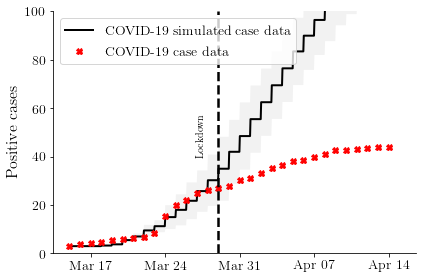

In [11]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_example, sim_cases.sum(axis=1), 
    title='Example', 
    filename=runstr + 'ex_00',
    figsize=(6, 4),
    start_date=start_date,
    errorevery=1, acc=1000, 
    lockdown_at=lockdown_at_day,
    ymax=100)


Example plot (b)

Optimize sigma using maximum likelihood estimation...
 0.50: 3
 0.50: 3
 0.01: 3
 0.01: 3
done. Best sigma found at: 0.01


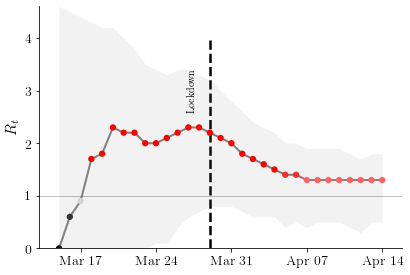

In [12]:
plotter = Plotter()
plotter.plot_daily_rts(
    summary_example,
    filename=runstr + 'ex_01',
    start_date=start_date,
    sigma=None,
    figsize=(6, 4), 
    subplot_adjust=None,
    lockdown_label='Lockdown', 
    lockdown_at=lockdown_at_day,
    lockdown_label_y=2.6,
    ymax=4.0)

Example plot (c)

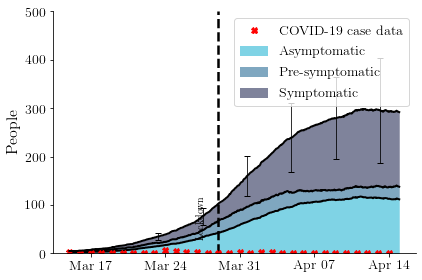

In [16]:
targets = sim_cases.sum(axis=1)
targets = np.hstack((targets[0], np.diff(targets)))

plotter = Plotter()
plotter.plot_daily_infected(
    summary_example,
    title='', 
    filename=runstr + 'ex_02',
    errorevery=100, acc=1000, 
    figsize=(6, 4),
    start_date=start_date,
    show_target=targets,
    lockdown_at=lockdown_at_day,
    lockdown_label_y=30,
    lockdown_label='Lockdown',
    ymax=500)

Example plot (d)

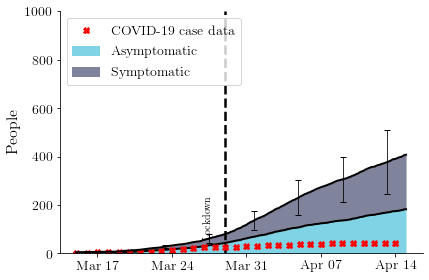

In [19]:
plotter = Plotter()
plotter.plot_cumulative_infected(
    summary_example,
    title='', 
    filename=runstr + 'ex_03',
    figsize=(6, 4),
    legend_loc='upper left',
    errorevery=100, acc=1000, 
    start_date=start_date,
    lockdown_at=lockdown_at_day,
    lockdown_label_y=60,
    show_target=sim_cases.sum(axis=1),
    ymax=1000)

In [55]:
from lib.calibrationFunctions import extract_seeds_from_summary

extract_seeds_from_summary(summary_example, max_time, sim_cases), max_time



All states:
susc 8732
expo 36
ipre 9
isym 103
iasy 75
posi 120
nega 0
resi 97
dead 2
hosp 4


({'expo': 36,
  'iasy': 75,
  'ipre': 9,
  'isym_posi': 75,
  'isym_notposi': 28,
  'resi_posi': 45,
  'resi_notposi': 54},
 744.0)